<h1> Modeling Football Sports Data - the modern MoneyBall </h1>

<h5> This project is about implementing Machine Learning Algorithms to leverage some insights about Football Players. </h5>

<h6> This Jupyter Notebook uses the final database.</h6>
<p> 1) Building the database - 4 Steps:
    <li> Collecting the EA Sports FIFA 19 Game Statistics of Football Players </li>
    <li> Web-Scraping the corresponding information on Transfermarkt website </li>
    <li> Web-Scraping the performances on ESPN FC website </li>
    <li> Web-Scraping the Instagram and Facebook followers for assessing the Marketing impact </li>
</p> 

<p> 2) Cleaning the dataset - 3 Steps:
    <li> Completing the missing values with players of similar characteristics </li>
    <li> Correcting outliers for instagram followers (small players confounded with very famous influencer) </li>
    <li> Removing players with a small amount of data </li>
</p> 

<p> For more information, please refer to the documentation. </p> 

<h6> There are 3 parts on this project:</h6>
<p>
    <li> Understanding the factors explaining the Market Value of a Player </li> 
    <li> Spotting the outstanding players (in terms of performances) over a season </li>
    <li> For a Club: decide the best replacement for a transfered player </li>

</p>

<h3> Import the useful libraries </h3>
<li> pandas: manipulate DataFrames</li>
<li> numpy: manipulate arrays</li>
<li> requests: scrape the missing content</li>
<li> bs4 - BeautifulSoup: find the data amongst scraped links </li>
<li> matplotlib: visualize Data </li>
<li> seaborn: fancy style for visualizing data </li>
<li> scipy: compute some statistics </li>
<li> sklearn: library for Machine Learning models </li>

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', 500)
import numpy as np

import requests
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from scipy import stats

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h1> Part 1: Understanding the factors behind a Player's Market Value </h1>

<h3> Preprocessing the Web-Scraped DataBase </h3>
<li> Step 1: convert the content and create columns into Python readable format </li>

In [2]:
football_non_processed = pd.read_csv('Data cleaned vf.csv')

# Defining the period at which the player joined the club (period 0 = beginning of 2000, period 37 = end of 2018, two periods per year)
for j in range (0,football_non_processed.shape[0]):
    year = int(football_non_processed.loc[j,'Day Joined'].split("-")[0])
    month = int(football_non_processed.loc[j,'Day Joined'].split("-")[1])
    day = int(football_non_processed.loc[j,'Day Joined'].split("-")[2])
    for i in range(0,19):
        year_ref_pred = 2000 + i - 1
        year_ref = 2000 + i
        if (year == year_ref_pred and month == 12):
            football_non_processed.loc[j,'Day Joined'] = 2*i
        if (year == year_ref and month >= 1 and month <= 5):
            football_non_processed.loc[j,'Day Joined'] = 2*i
        if (year == year_ref and month <= 11 and month >= 6):
            football_non_processed.loc[j,'Day Joined'] = 2*i + 1


# Split the column LEAGUE into League location and League Name
def get_league_location(league):
    league_location = league.split(' ', 1)[0]
    return league_location

def get_league_name(league):
    league_name = league.split(' ',1)[1]
    return league_name

continents = {'Italy': 'Europe','Spain':'Europe','France':'Europe','England':'Europe',
             'Germany':'Europe','Japan':'Asia','Turkey':'Europe','Portugal':'Europe',
             'China':'Asia','USA':'North America','Ukraine':'Europe','Holland':'Europe',
             'Russia':'Europe','Mexico':'North America','Belgium':'Europe','Greece':'Europe',
             'Argentina':'South America','Colombia':'South America','Saudi':'Asia',
              'Austria':'Europe','Scotland':'Europe','Switzerland':'Europe','Czech':'Europe',
             'Denmark':'Europe','Croatia':'Europe','Norway':'Europe','Sweden':'Europe',
             'Korea':'Asia','Poland':'Europe','Rep.':'Europe','Australia': 'Oceania'}

football_non_processed['LEAGUE LOCATION'] = football_non_processed['LEAGUE'].apply(lambda x: get_league_location(x))
football_non_processed['LEAGUE NAME'] = football_non_processed['LEAGUE'].apply(lambda x: get_league_name(x))
football_non_processed['CONTINENT'] = football_non_processed['LEAGUE LOCATION'].apply(lambda x: continents[x])

cols = list(football_non_processed.columns.values) 
cols.pop(cols.index('LEAGUE LOCATION')) 
cols.pop(cols.index('LEAGUE NAME'))
cols.pop(cols.index('CONTINENT'))
football_non_processed = football_non_processed[cols[0:4]+ ['CONTINENT','LEAGUE LOCATION','LEAGUE NAME']+cols[4:]]


# Drop multiple player names values
football_non_processed = football_non_processed.drop([2166,4652,5256,3993,3994,3995,3996,3997,3454], axis = 0)

football_non_processed.head(20)

,Player ID,NAME,CLUB,LEAGUE,CONTINENT,LEAGUE LOCATION,LEAGUE NAME,POSITION,TIER,PACE,PHYSICAL,Date of Birth,Age,Nationality,Height,Foot,Day Joined,Contract End,Days in Club,Days left end Contract,Insta Players foll,Club FB Likes,GS2017,SB2017,G2017,A2017,SH2017,SG2017,FC2017,FS2017,YC2017,RC2017,GS2016,SB2016,G2016,A2016,SH2016,SG2016,FC2016,FS2016,YC2016,RC2016,GS2015,SB2015,G2015,A2015,SH2015,SG2015,FC2015,FS2015,YC2015,RC2015,GS2014,SB2014,G2014,A2014,SH2014,SG2014,FC2014,FS2014,YC2014,RC2014,GS2013,SB2013,G2013,A2013,SH2013,SG2013,FC2013,FS2013,YC2013,RC2013,Ball Control 17,Dribbling 17,Marking 17,Slide Tackle 17,Stand Tackle 17,Agression 17,Reactions 17,Att Position 17,Interceptions 17,Vision 17,Crossing 17,Short Pass 17,Long Pass 17,Acceleration 17,Stamina 17,Strength 17,Balance 17,Sprint Speed 17,Agility 17,Jumping 17,Heading 17,Shot Power 17,Finishing 17,Long Shots 17,Curve 17,Ball Control 16,Dribbling 16,Marking 16,Slide Tackle 16,Stand Tackle 16,Agression 16,Reactions 16,Att Position 16,Interceptions 16,Vision 16,Crossing 16,Short Pass 16,Long Pass 16,Acceleration 16,Stamina 16,Strength 16,Balance 16,Sprint Speed 16,Agility 16,Jumping 16,Heading 16,Shot Power 16,Finishing 16,Long Shots 16,Curve 16,Ball Control 15,Dribbling 15,Marking 15,Slide Tackle 15,Stand Tackle 15,Agression 15,Reactions 15,Att Position 15,Interceptions 15,Vision 15,Crossing 15,Short Pass 15,Long Pass 15,Acceleration 15,Stamina 15,Strength 15,Balance 15,Sprint Speed 15,Agility 15,Jumping 15,Heading 15,Shot Power 15,Finishing 15,Long Shots 15,Curve 15,Ball Control 14,Dribbling 14,Marking 14,Slide Tackle 14,Stand Tackle 14,Agression 14,Reactions 14,Att Position 14,Interceptions 14,Vision 14,Crossing 14,Short Pass 14,Long Pass 14,Acceleration 14,Stamina 14,Strength 14,Balance 14,Sprint Speed 14,Agility 14,Jumping 14,Heading 14,Shot Power 14,Finishing 14,Long Shots 14,Curve 14,Ball Control 13,Dribbling 13,Marking 13,Slide Tackle 13,Stand Tackle 13,Agression 13,Reactions 13,Att Position 13,Interceptions 13,Vision 13,Crossing 13,Short Pass 13,Long Pass 13,Acceleration 13,Stamina 13,Strength 13,Balance 13,Sprint Speed 13,Agility 13,Jumping 13,Heading 13,Shot Power 13,Finishing 13,Long Shots 13,Curve 13,Market Value
0,0,Cristiano Ronaldo,Juventus,Italy Serie A,Europe,Italy,Serie A,ST,Gold,90.0,79.0,1985-02-05,33,Portugal,187,both,37,2022-06-30,128,1323,145300000.0,17827150,48.0,2.0,48.0,10.0,305.0,128.0,28.0,46.0,3.0,1.0,56.0,0.0,48.0,14.0,334.0,124.0,37.0,93.0,6.0,0.0,61.0,1.0,67.0,18.0,406.0,175.0,40.0,85.0,5.0,0.0,56.0,2.0,61.0,22.0,340.0,154.0,42.0,96.0,6.0,1.0,60.0,0.0,65.0,15.0,366.0,164.0,38.0,102.0,10.0,1.0,94.0,88.0,28.0,23.0,31.0,63.0,96.0,95.0,29.0,82.0,84.0,81.0,77.0,89.0,88.0,79.0,70.0,91.0,87.0,95.0,89.0,95.0,94.0,93.0,81.0,93.0,91.0,22.0,23.0,31.0,63.0,96.0,95.0,29.0,85.0,85.0,83.0,77.0,89.0,92.0,80.0,63.0,91.0,89.0,95.0,88.0,94.0,94.0,92.0,81.0,93.0,92.0,22.0,23.0,31.0,63.0,96.0,94.0,29.0,85.0,84.0,83.0,77.0,91.0,92.0,80.0,63.0,92.0,90.0,95.0,85.0,92.0,93.0,90.0,81.0,91.0,93.0,22.0,23.0,31.0,62.0,92.0,93.0,29.0,81.0,82.0,81.0,72.0,91.0,90.0,79.0,62.0,93.0,90.0,94.0,86.0,94.0,95.0,93.0,88.0,92.0,93.0,22.0,23.0,31.0,63.0,90.0,91.0,24.0,81.0,83.0,82.0,72.0,91.0,89.0,79.0,63.0,94.0,93.0,94.0,86.0,94.0,95.0,93.0,88.0,100000000
1,1,Lionel Messi,FC Barcelona,Spain Primera Division,Europe,Spain,Primera Division,CF,Gold,88.0,61.0,1987-06-24,31,Argentina,170,left,11,2021-06-30,4885,958,100900000.0,102694440,54.0,6.0,47.0,21.0,311.0,146.0,28.0,137.0,7.0,0.0,57.0,4.0,59.0,21.0,273.0,114.0,26.0,147.0,10.0,0.0,64.0,3.0,52.0,28.0,325.0,143.0,31.0,190.0,6.0,0.0,66.0,2.0,65.0,29.0,316.0,157.0,43.0,163.0,6.0,0.0,50.0,6.0,46.0,13.0,224.0,98.0,15.0,91.0,3.0,0.0,96.0,97.0,33.0,26.0,28.0,48.0,95.0,94.0,22.0,94.0,77.0,90.0,87.0,91.0,72.0,59.0,95.0,86.0,91.0,68.0,70.0,85.0,95.0,94.0,93.0,96.0,97.0,13.0,26.0,28.0,48.0,95.0,93.0,22.0,92.0,77.0,88.0,87.0,92.0,73.0,59.0,95.0,87.0,90.0,67.0,71.0,85.0,95.0,88.0,90.0,95.0,97.0,13.0,26.0,28.0,48.0,95.0,93.0,22.0,90.0,77.

<h3> Preprocessing the Web-Scraped DataBase </h3>
<li> Step 1: convert the content and create columns into Python readable format </li>
<li> Step 2: select the columns to keep and convert the text columns into dummy variables </li>

In [3]:
football = football_non_processed.copy()

# Select the columns to keep
cols = list(football.columns.values)
keep = cols[2:5] + cols[7:8] + cols[9:11] + cols[12:17] + cols[18:-1]

# Preprocess CONTINENT
continent = football['CONTINENT'].unique()
le_continent = preprocessing.LabelEncoder()
le_continent.fit(continent)
football['CONTINENT'] = le_continent.transform(football['CONTINENT']) 

# Preprocess LEAGUE LOCATION
league_name = football['LEAGUE NAME'].unique()
le_league_name = preprocessing.LabelEncoder()
le_league_name.fit(league_name)
football['LEAGUE NAME'] = le_league_name.transform(football['LEAGUE NAME']) 

# Preprocess LEAGUE NAME
league_location = football['LEAGUE LOCATION'].unique()
le_league_location = preprocessing.LabelEncoder()
le_league_location.fit(league_location)
football['LEAGUE LOCATION'] = le_league_location.transform(football['LEAGUE LOCATION']) 

# Preprocess Clubs
clubs = football['CLUB'].unique()
le_club = preprocessing.LabelEncoder()
le_club.fit(clubs)
football['CLUB'] = le_club.transform(football['CLUB']) 

# Preprocess Leagues
leagues = football['LEAGUE'].unique()
le_league = preprocessing.LabelEncoder()
le_league.fit(leagues)
football['LEAGUE'] = le_league.transform(football['LEAGUE']) 

# Preprocess Positions
positions = football['POSITION'].unique()
le_position = preprocessing.LabelEncoder()
le_position.fit(positions)
football['POSITION'] = le_position.transform(football['POSITION']) 

# Preprocess Nationalities
nationalities = football['Nationality'].unique()
le_nationality = preprocessing.LabelEncoder()
le_nationality.fit(nationalities)
football['Nationality'] = le_nationality.transform(football['Nationality']) 

# Preprocess Feet
feet = football['Foot'].unique()
le_foot = preprocessing.LabelEncoder()
le_foot.fit(feet)
football['Foot'] = le_foot.transform(football['Foot']) 

# Preprocess Days joined
day_joined = football['Day Joined'].unique()
le_day_joined = preprocessing.LabelEncoder()
le_day_joined.fit(day_joined)
football['Day Joined'] = le_day_joined.transform(football['Day Joined'])

# Preprocess Market Value
football['Market Value'] = football['Market Value'].apply(lambda x: int(x))


# Keep the columns of interest for fitting the model
X = football[keep].values
y = football['Market Value'].values
 

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)


# Feature Scaling
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)


<h3> Fit a Random Forest regression model </h3>
<li> Based on a grid search, choice of 200 estimators </li>
<li> Evaluate the MSE, RMSE and R^2 </li>

In [4]:
regressor_rf = RandomForestRegressor(n_estimators=200, n_jobs = -1)  
regressor_rf.fit(X_train, y_train)

y_pred = regressor_rf.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))#-data['Market Value'].mean())/data['Market Value'].std())  
print('R-squared:', metrics.r2_score(y_test, y_pred))


Mean Absolute Error: 2075183.2609897768
Mean Squared Error: 26415724722804.402
Root Mean Squared Error: 5139623.013685381
R-squared: 0.8274976961655665


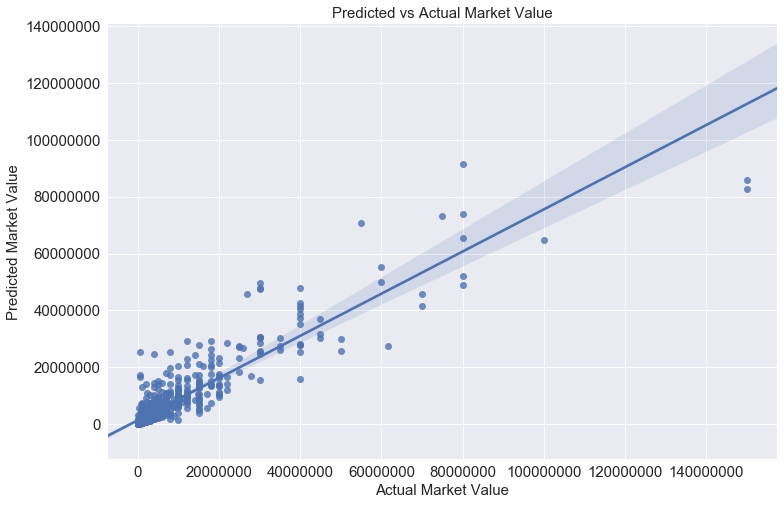

In [5]:
# Scatter plot unique actual market value vs predictions
plt.figure(figsize=(12,8))

ax = sns.regplot(x=y_test, y=y_pred)
ax.set_title('Predicted vs Actual Market Value', fontsize = 15)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Predicted Market Value', fontsize = 15)
ax.set_xlabel('Actual Market Value', fontsize = 15)
ax.tick_params(labelsize=15)

<h3> Display 10 first important features </h3>

In [6]:
rf_feature_importance_table = pd.DataFrame({
        'feature':keep,
        'importance':regressor_rf.feature_importances_
    })

rf_feature_importance_table.sort_values('importance', ascending=False, inplace=True)
rf_feature_importance_table[0:10]

,feature,importance
14,Club FB Likes,0.243569
71,Reactions 17,0.184742
65,Ball Control 17,0.069652
6,Age,0.040551
15,GS2017,0.030693
20,SG2017,0.027949
19,SH2017,0.021774
12,Days left end Contract,0.019319
72,Att Position 17,0.015400
17,G2017,0.014790


<h3> Fit a linear Regression on the top 10 features </h3>
<li> The Random Forest model does not allow to quantify the financial impact of each variable </li>
<li> A simple linear regression on the 10 top features gives a sense of how each variable changes the Market Value of a Player </li>

In [7]:
X = football.loc[:, ['Club FB Likes','Reactions 17','Ball Control 17','Age','SG2017',
                    'GS2017','SH2017','Insta Players foll','Days left end Contract',
                    'G2017']].values

y = football.loc[:, 'Market Value'].values

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train = X_train
y_train = y_train.reshape(-1,1)


# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

print('Linear Regression on the 10 most important features')
print('---------------------------------------------------')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('R-squared:', metrics.r2_score(y_test, y_pred))

pd.DataFrame(regressor.coef_.reshape(10,1), columns = ['Coefficients'],index = ['Club FB Likes','Reactions 17','Ball Control 17','Age','SG2017',
                    'GS2017','SH2017','Insta Players foll','Days left end Contract',
                    'G2017'])


Linear Regression on the 10 most important features
---------------------------------------------------
Mean Absolute Error: 4163623.893262204
Mean Squared Error: 62675989732512.76
Root Mean Squared Error: 7916816.893961408
R-squared: 0.590707703937114


,Coefficients
Club FB Likes,0.382317
Reactions 17,335135.289088
Ball Control 17,13960.255692
Age,-352055.764618
SG2017,150368.360902
GS2017,41171.713267
SH2017,31455.120234
Insta Players foll,0.266226
Days left end Contract,3762.289920
G2017,85725.536508


<h6> This shows for example that an Instagram Player Followers relates to $0.26 of your Market Value </h6>

<h1> Part 2: Spotting the outstanding players on a specific season </h1>

<h3> Look at the Strikers who have been lucky or performed very good last season </h3>
<p> Assessing the shrinkage coefficient to quantify what part is luck and what part is skill for strikers:
    <li> Select the strikers </li>
    <li> Calculate the mean of their goals in 2015-2016 season </li>
    <li> Fit a linear regression on their Goals in 2016-2017 vs 2015-2016 </li>
    <li> Evaluate the shrinkage coefficient </li>
    <li> Using the results of the linear regression predict the number of goals during 2017-2018 given 2016-2017 performances </li>
    <li> Spot the best and worst performing strikers for this season </li>
</p> 

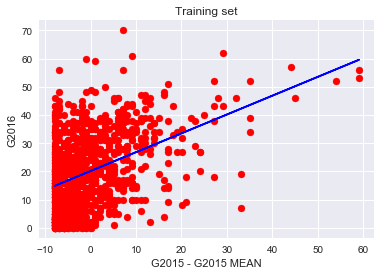

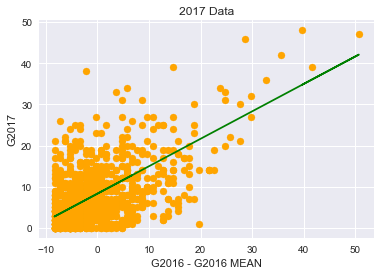

In [8]:
strikers = football_non_processed[(football_non_processed['POSITION'] == 'ST')|(football_non_processed['POSITION'] == 'CF')].copy()
strikers['G2015 MEAN'] = strikers['G2015'].mean()
strikers['Fitting Variable'] = strikers.apply(lambda x: x['G2015']-x['G2015 MEAN'],axis = 1)
X = strikers.iloc[:, 199].values
y = strikers.iloc[:, 32].values

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0, random_state = 0)
X_train = X_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
#X_test = X_test.reshape(-1,1)

# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
#y_pred = regressor.predict(X_test)

# Visualising the Training set results
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Training set')
plt.xlabel('G2015 - G2015 MEAN')
plt.ylabel('G2016')
plt.show()

c = regressor.coef_[0][0]

# Predict the performance on 2017-2018 season
plt.scatter(strikers['G2016'].values - strikers['G2016'].mean(), strikers['G2017'].values,color = 'Orange')
plt.plot(strikers['G2016'].values - strikers['G2016'].mean(), strikers['G2016'].mean()+ c*(strikers['G2016'].values - strikers['G2016'].mean()), color = 'green')
plt.title('2017 Data')
plt.xlabel('G2016 - G2016 MEAN')
plt.ylabel('G2017')
plt.show()

strikers['G2017 Pred'] = strikers['G2016'].apply(lambda x: strikers['G2016'].mean()+ c*(x - strikers['G2016'].mean()))
strikers['G2017 Diff'] = strikers.apply(lambda x: x['G2017']-x['G2017 Pred'],axis = 1)

most_diff = strikers.sort_values(by=['G2017 Diff'], ascending = False)




In [9]:
# Most constant players over the three last years
most_diff[(most_diff['TIER'] == 'Gold') & (np.abs(most_diff['G2017 Diff'])<=2)].head(10)

,Player ID,NAME,CLUB,LEAGUE,CONTINENT,LEAGUE LOCATION,LEAGUE NAME,POSITION,TIER,PACE,PHYSICAL,Date of Birth,Age,Nationality,Height,Foot,Day Joined,Contract End,Days in Club,Days left end Contract,Insta Players foll,Club FB Likes,GS2017,SB2017,G2017,A2017,SH2017,SG2017,FC2017,FS2017,YC2017,RC2017,GS2016,SB2016,G2016,A2016,SH2016,SG2016,FC2016,FS2016,YC2016,RC2016,GS2015,SB2015,G2015,A2015,SH2015,SG2015,FC2015,FS2015,YC2015,RC2015,GS2014,SB2014,G2014,A2014,SH2014,SG2014,FC2014,FS2014,YC2014,RC2014,GS2013,SB2013,G2013,A2013,SH2013,SG2013,FC2013,FS2013,YC2013,RC2013,Ball Control 17,Dribbling 17,Marking 17,Slide Tackle 17,Stand Tackle 17,Agression 17,Reactions 17,Att Position 17,Interceptions 17,Vision 17,Crossing 17,Short Pass 17,Long Pass 17,Acceleration 17,Stamina 17,Strength 17,Balance 17,Sprint Speed 17,Agility 17,Jumping 17,Heading 17,Shot Power 17,Finishing 17,Long Shots 17,Curve 17,Ball Control 16,Dribbling 16,Marking 16,Slide Tackle 16,Stand Tackle 16,Agression 16,Reactions 16,Att Position 16,Interceptions 16,Vision 16,Crossing 16,Short Pass 16,Long Pass 16,Acceleration 16,Stamina 16,Strength 16,Balance 16,Sprint Speed 16,Agility 16,Jumping 16,Heading 16,Shot Power 16,Finishing 16,Long Shots 16,Curve 16,Ball Control 15,Dribbling 15,Marking 15,Slide Tackle 15,Stand Tackle 15,Agression 15,Reactions 15,Att Position 15,Interceptions 15,Vision 15,Crossing 15,Short Pass 15,Long Pass 15,Acceleration 15,Stamina 15,Strength 15,Balance 15,Sprint Speed 15,Agility 15,Jumping 15,Heading 15,Shot Power 15,Finishing 15,Long Shots 15,Curve 15,Ball Control 14,Dribbling 14,Marking 14,Slide Tackle 14,Stand Tackle 14,Agression 14,Reactions 14,Att Position 14,Interceptions 14,Vision 14,Crossing 14,Short Pass 14,Long Pass 14,Acceleration 14,Stamina 14,Strength 14,Balance 14,Sprint Speed 14,Agility 14,Jumping 14,Heading 14,Shot Power 14,Finishing 14,Long Shots 14,Curve 14,Ball Control 13,Dribbling 13,Marking 13,Slide Tackle 13,Stand Tackle 13,Agression 13,Reactions 13,Att Position 13,Interceptions 13,Vision 13,Crossing 13,Short Pass 13,Long Pass 13,Acceleration 13,Stamina 13,Strength 13,Balance 13,Sprint Speed 13,Agility 13,Jumping 13,Heading 13,Shot Power 13,Finishing 13,Long Shots 13,Curve 13,Market Value,G2015 MEAN,Fitting Variable,G2017 Pred,G2017 Diff
1441,1658,Andrea Petagna,Spal,Italy Serie A,Europe,Italy,Serie A,ST,Gold,89.0,71.0,1995-06-30,23,Italy,190,left,37,2020-06-30,119,593,4.370000e+04,54371,33.0,11.0,8.0,7.0,70.0,24.0,37.0,60.0,7.0,0.0,31.0,3.0,5.0,7.0,67.0,26.0,58.0,69.0,2.0,0.0,2.0,5.0,10.0,3.0,56.0,24.0,37.0,37.0,2.0,0.0,0.0,4.0,5.0,1.0,20.0,9.0,16.0,16.0,2.0,0.0,2.0,10.0,0.0,0.0,3.0,0.0,10.0,6.0,1.0,0.0,78.0,74.0,57.0,15.0,20.0,60.0,69.0,77.0,18.0,70.0,58.0,74.0,56.0,52.0,74.0,90.0,62.0,67.0,56.0,69.0,77.0,76.0,74.0,56.0,54.0,78.0,74.0,15.0,15.0,20.0,60.0,69.0,77.0,18.0,70.0,58.0,74.0,56.0,54.0,76.0,90.0,62.0,68.0,56.0,69.0,77.0,76.0,74.0,56.0,54.0,74.0,69.0,15.0,15.0,15.0,60.0,69.0,75.0,18.0,63.0,49.0,70.0,48.0,61.0,68.0,90.0,61.0,60.0,56.0,71.0,77.0,76.0,74.0,49.0,46.0,68.0,57.0,15.0,15.0,14.0,50.0,56.0,63.0,15.0,35.0,42.0,60.0,38.0,60.0,68.0,90.0,58.0,64.0,56.0,68.0,68.0,72.0,65.0,38.0,46.0,64.0,54.0,25.0,25.0,25.0,49.0,55.0,61.0,25.0,21.0,25.0,59.0,33.0,60.0,74.0,86.0,58.0,64.0,54.0,68.0,67.0,71.0,64.0,37.0,45.0,9000000,7.944009,2.055991,6.105084,1.894916
886,941,Felipe Caicedo,Lazio,Italy Serie A,Europe,Italy,Serie A,ST,Gold,83.0,72.0,1988-09-05,30,Ecuador,183,left,35,2020-06-30,470,593,7.300000e+04,818436,10.0,21.0,6.0,3.0,33.0,17.0,34.0,11.0,1.0,0.0,16.0,13.0,2.0,1.0,16.0,6.0,60.0,19.0,3.0,1.0,41.0,6.0,17.0,0.0,69.0,34.0,72.0,53.0,8.0,0.0,35.0,15.0,10.0,2.0,40.0,23.0,69.0,28.0,3.0,0.0,18.0,12.0,10.0,0.0,26.0,12.0,11.0,10.0,4.0,0.0,77.0,72.0,32.0,47.0,44.0,80.0,78.0,82.0,43.0,61.0,59.0,69.0,53.0,69.0,54.0,90.0,67.0,69.0,61.0,75.0,75.0,84.0,72.0,68.0,66.0,77.0,72.0,42.0,47.0,44.0,80.0,78.0,82.0,43.0,61.0,59.0,69.0,53.0,70.0,66.0,90.0,67.0,74.0,61.0,75.0,75.0,84.0,72.0,68.0,66.0,77.0,72.0,42.0,47.0,44.0,81.0,78.0,82.0,43.0

In [10]:
# Most growing or lucky players over the last year
most_diff[(most_diff['TIER'] == 'Gold')].head(10)

,Player ID,NAME,CLUB,LEAGUE,CONTINENT,LEAGUE LOCATION,LEAGUE NAME,POSITION,TIER,PACE,PHYSICAL,Date of Birth,Age,Nationality,Height,Foot,Day Joined,Contract End,Days in Club,Days left end Contract,Insta Players foll,Club FB Likes,GS2017,SB2017,G2017,A2017,SH2017,SG2017,FC2017,FS2017,YC2017,RC2017,GS2016,SB2016,G2016,A2016,SH2016,SG2016,FC2016,FS2016,YC2016,RC2016,GS2015,SB2015,G2015,A2015,SH2015,SG2015,FC2015,FS2015,YC2015,RC2015,GS2014,SB2014,G2014,A2014,SH2014,SG2014,FC2014,FS2014,YC2014,RC2014,GS2013,SB2013,G2013,A2013,SH2013,SG2013,FC2013,FS2013,YC2013,RC2013,Ball Control 17,Dribbling 17,Marking 17,Slide Tackle 17,Stand Tackle 17,Agression 17,Reactions 17,Att Position 17,Interceptions 17,Vision 17,Crossing 17,Short Pass 17,Long Pass 17,Acceleration 17,Stamina 17,Strength 17,Balance 17,Sprint Speed 17,Agility 17,Jumping 17,Heading 17,Shot Power 17,Finishing 17,Long Shots 17,Curve 17,Ball Control 16,Dribbling 16,Marking 16,Slide Tackle 16,Stand Tackle 16,Agression 16,Reactions 16,Att Position 16,Interceptions 16,Vision 16,Crossing 16,Short Pass 16,Long Pass 16,Acceleration 16,Stamina 16,Strength 16,Balance 16,Sprint Speed 16,Agility 16,Jumping 16,Heading 16,Shot Power 16,Finishing 16,Long Shots 16,Curve 16,Ball Control 15,Dribbling 15,Marking 15,Slide Tackle 15,Stand Tackle 15,Agression 15,Reactions 15,Att Position 15,Interceptions 15,Vision 15,Crossing 15,Short Pass 15,Long Pass 15,Acceleration 15,Stamina 15,Strength 15,Balance 15,Sprint Speed 15,Agility 15,Jumping 15,Heading 15,Shot Power 15,Finishing 15,Long Shots 15,Curve 15,Ball Control 14,Dribbling 14,Marking 14,Slide Tackle 14,Stand Tackle 14,Agression 14,Reactions 14,Att Position 14,Interceptions 14,Vision 14,Crossing 14,Short Pass 14,Long Pass 14,Acceleration 14,Stamina 14,Strength 14,Balance 14,Sprint Speed 14,Agility 14,Jumping 14,Heading 14,Shot Power 14,Finishing 14,Long Shots 14,Curve 14,Ball Control 13,Dribbling 13,Marking 13,Slide Tackle 13,Stand Tackle 13,Agression 13,Reactions 13,Att Position 13,Interceptions 13,Vision 13,Crossing 13,Short Pass 13,Long Pass 13,Acceleration 13,Stamina 13,Strength 13,Balance 13,Sprint Speed 13,Agility 13,Jumping 13,Heading 13,Shot Power 13,Finishing 13,Long Shots 13,Curve 13,Market Value,G2015 MEAN,Fitting Variable,G2017 Pred,G2017 Diff
1009,1100,Mata,Getafe CF,Spain Primera Division,Europe,Spain,Primera Division,ST,Gold,86.0,69.0,1988-10-24,30,Spain,186,right,37,2021-06-30,137,958,76000.0,117514,44.0,3.0,38.0,0.0,38.0,38.0,1.0,0.0,15.0,0.0,19.0,11.0,6.0,0.0,10.0,7.0,2.0,1.0,5.0,2.0,30.0,11.0,9.0,0.0,9.0,9.0,0.0,0.0,9.0,1.0,30.0,12.0,14.0,0.0,14.0,14.0,0.0,0.0,7.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,82.0,42.0,21.0,31.0,50.0,85.0,83.0,39.0,85.0,83.0,85.0,79.0,69.0,71.0,37.0,89.0,62.0,84.0,70.0,56.0,75.0,78.0,72.0,84.0,88.0,82.0,25.0,21.0,31.0,54.0,84.0,83.0,39.0,86.0,84.0,86.0,79.0,71.0,78.0,43.0,89.0,63.0,85.0,72.0,59.0,75.0,78.0,70.0,84.0,88.0,83.0,25.0,21.0,28.0,52.0,85.0,84.0,39.0,87.0,83.0,86.0,77.0,75.0,74.0,43.0,89.0,63.0,89.0,72.0,63.0,75.0,80.0,70.0,84.0,88.0,85.0,25.0,21.0,28.0,52.0,87.0,84.0,39.0,88.0,83.0,86.0,77.0,78.0,76.0,43.0,89.0,63.0,90.0,72.0,63.0,74.0,77.0,72.0,83.0,88.0,85.0,25.0,25.0,22.0,52.0,87.0,84.0,39.0,88.0,83.0,86.0,78.0,83.0,79.0,41.0,89.0,66.0,90.0,72.0,66.0,74.0,77.0,72.0,82.0,5000000,7.944009,1.055991,6.771692,31.228308
103,104,Jonas,SL Benfica,Portugal Liga NOS,Europe,Portugal,Liga NOS,ST,Gold,90.0,57.0,1984-04-01,34,Brazil,182,right,29,2019-06-30,1525,227,175000000.0,3672549,33.0,5.0,34.0,5.0,146.0,69.0,39.0,59.0,2.0,0.0,18.0,5.0,14.0,5.0,70.0,38.0,28.0,40.0,2.0,0.0,45.0,3.0,35.0,2.0,63.0,47.0,15.0,18.0,7.0,0.0,25.0,2.0,20.0,0.0,20.0,20.0,0.0,0.0,4.0,0.0,30.0,13.0,11.0,2.0,101.0,45.0,34.0,42.0,7.0,1.0,88.0,84.0,31.0,25.0,36.0,61.0,85.0,87.0,34.0,83.0,70.0,76.0,75.0,65.0,66.0,63.0,69.0,64.0,77.0,69.0,84.0,84.0,88.0,85.0,85.0,89.0,84.0,23.0,25.0,36.0,61.0,85.0,87.0,34.0,83.0,70.0,75.0,70.0,66.0,74.0,61.0,69.0,65.0,77.0,69.0,84.0,84.0,88.0,85.0,85.0,88.0,84.0,23.0,25.0,36.0,61.0,83.0

<h1> Part 3: Find the best replacement for a leaving player </h1>

<h2> Find the Closest players using K-Means</h2>
<p> The best fitting players are the ones with similar characteristics and performances </p>
<h3> Preprocessing the Web-Scraped DataBase </h3>
<li> Step 1: convert the content and create columns into Python readable format </li>
<li> Step 2: select the columns to keep and convert the text columns into dummy variables </li>
<li> Step 3: create the distance matrix </li>

In [11]:
football = football_non_processed[football_non_processed['TIER']=='Gold'].copy()

cols = list(football.columns.values)
cols


keep = cols[2:5] + cols[7:8] + cols[9:11] + cols[12:17] + cols[18:-1]

# Preprocess CONTINENT
continent = football['CONTINENT'].unique()
le_continent = preprocessing.LabelEncoder()
le_continent.fit(continent)
football['CONTINENT'] = le_continent.transform(football['CONTINENT']) 

# Preprocess LEAGUE LOCATION
league_name = football['LEAGUE NAME'].unique()
le_league_name = preprocessing.LabelEncoder()
le_league_name.fit(league_name)
football['LEAGUE NAME'] = le_league_name.transform(football['LEAGUE NAME']) 

# Preprocess LEAGUE NAME
league_location = football['LEAGUE LOCATION'].unique()
le_league_location = preprocessing.LabelEncoder()
le_league_location.fit(league_location)
football['LEAGUE LOCATION'] = le_league_location.transform(football['LEAGUE LOCATION']) 

# Preprocess Clubs
clubs = football['CLUB'].unique()
le_club = preprocessing.LabelEncoder()
le_club.fit(clubs)
football['CLUB'] = le_club.transform(football['CLUB']) 

# Preprocess Leagues
leagues = football['LEAGUE'].unique()
le_league = preprocessing.LabelEncoder()
le_league.fit(leagues)
football['LEAGUE'] = le_league.transform(football['LEAGUE']) 

# Preprocess Positions
positions = football['POSITION'].unique()
le_position = preprocessing.LabelEncoder()
le_position.fit(positions)
football['POSITION'] = le_position.transform(football['POSITION']) 

# Preprocess Nationalities
nationalities = football['Nationality'].unique()
le_nationality = preprocessing.LabelEncoder()
le_nationality.fit(nationalities)
football['Nationality'] = le_nationality.transform(football['Nationality']) 

# Preprocess Feet
feet = football['Foot'].unique()
le_foot = preprocessing.LabelEncoder()
le_foot.fit(feet)
football['Foot'] = le_foot.transform(football['Foot']) 

# Preprocess Days joined
day_joined = football['Day Joined'].unique()
le_day_joined = preprocessing.LabelEncoder()
le_day_joined.fit(day_joined)
football['Day Joined'] = le_day_joined.transform(football['Day Joined'])

# Preprocess Market Value
football['Market Value'] = football['Market Value'].apply(lambda x: int(x))


X = football[keep]
y = football['Market Value']



# Splitting the dataset into the Training set and Test set


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Feature Scaling
sc = StandardScaler()  
X = sc.fit_transform(X)
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)


from scipy.spatial import distance_matrix
dist = distance_matrix(X,X)

football_knn = football_non_processed.copy()
df_dist = pd.DataFrame(dist, index = football_non_processed[football_non_processed['TIER']=='Gold']['NAME'], columns = football_non_processed[football_non_processed['TIER']=='Gold']['NAME'])

football_knn = football_non_processed[football_non_processed['TIER']=='Gold'].copy()
football_knn.index = football_knn['NAME']


<h3> Choosing the right value of k </h3>

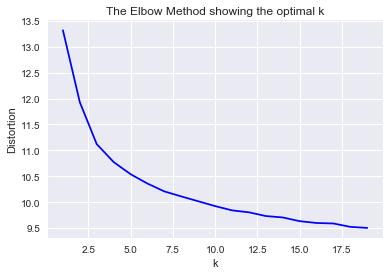

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<p> We choose a value of k = 7 </p>

<h3> Choosing the closest player to be replaced for Big Transfers this summer (2018) and finding overpaying clubs </h3>

In [13]:
transfered = ["Riyad Mahrez", "Steven Nzonzi","Gonzalo Higuaín","Jorginho","Thomas Lemar",
              "Naby Keïta","Cristiano Ronaldo","Fred","Fabinho","Radja Nainggolan","João Cancelo",
             "Michy Batshuayi","Felipe Anderson","Thilo Kehrer","Clément Lenglet", "Arturo Vidal",
             "Arthur","Emre Can","Mateo Kovačić","Keita Baldé","Nacer Chadli","Moussa Dembélé","Bernat"]

for k in transfered:
        print('---------------------------------------------------------------------------------------------------------------------')
        print('Player: ', k,'-',football_knn.loc[k,'Age'],'years old','|', "{:,}".format(football_knn.loc[k,'Market Value']), '€', ' | Buying Club: ',football_knn.loc[k,'CLUB'])
        print('Best fits:',' - '.join(list(df_dist.sort_values(by=[k]).index[1:7+1])))
        print('Average Market Value of these players:',"{:,}".format(int(football_knn.loc[list(df_dist.sort_values(by=[k]).index[1:i+1]),
                                       'Market Value'].mean())),'€', '| Average age:', int(football_knn.loc[list(df_dist.sort_values(by=[k]).index[1:i+1]),
                                       'Age'].mean()),'years old')
        print('Difference of price paid: ',"{:,}".format(int(football_knn.loc[k,'Market Value']- football_knn.loc[list(df_dist.sort_values(by=[k]).index[1:i+1]),
                                       'Market Value'].mean())),'€')
        
print('---------------------------------------------------------------------------------------------------------------------')        

---------------------------------------------------------------------------------------------------------------------
Player:  Riyad Mahrez - 27 years old | 60,000,000 €  | Buying Club:  Manchester City
Best fits: Diego Perotti - Alejandro Gómez - Yunus Mallı - Simone Verdi - Bernardo Silva - Stephan El Shaarawy - Suso
Average Market Value of these players: 32,888,888 € | Average age: 26 years old
Difference of price paid:  27,111,111 €
---------------------------------------------------------------------------------------------------------------------
Player:  Steven Nzonzi - 29 years old | 30,000,000 €  | Buying Club:  Roma
Best fits: Iborra - Sami Khedira - Nemanja Matić - Jasmin Kurtić - Younousse Sankharé - Victor Wanyama - Milan Badelj
Average Market Value of these players: 12,666,666 € | Average age: 29 years old
Difference of price paid:  17,333,333 €
---------------------------------------------------------------------------------------------------------------------
Player:  G

Average Market Value of these players: 7,007,777 € | Average age: 28 years old
Difference of price paid:  7,992,222 €
---------------------------------------------------------------------------------------------------------------------
Player:  Moussa Dembélé - 22 years old | 20,000,000 €  | Buying Club:  Tottenham Hotspur
Best fits: Vincent Janssen - Abel Hernández - Jonathan Kodjia - Giovanni Simeone - Andy Delort - Khouma Babacar - Michy Batshuayi
Average Market Value of these players: 12,222,222 € | Average age: 25 years old
Difference of price paid:  7,777,777 €
---------------------------------------------------------------------------------------------------------------------
Player:  Bernat - 25 years old | 10,000,000 €  | Buying Club:  Paris Saint-Germain
Best fits: Vieirinha - Layvin Kurzawa - Toño García - Abdul Rahman Baba - Raphaël Guerreiro - Fabian Johnson - Roberto Rosales
Average Market Value of these players: 9,000,000 € | Average age: 27 years old
Difference of price